In [1]:
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
file_path=r"C:\Users\MSI\OneDrive\Desktop\voicecom\reviews.xlsx"
df = pd.read_excel(file_path)

print(df.head())
print(df.shape)
print(df.columns)
print(df.dtypes)
print(df.describe())
print(df.isnull().sum())
print(df.info())

     rating                                             review
0  negative  terrible place to work for i just heard a stor...
1  negative   hours , minutes total time for an extremely s...
2  negative  my less than stellar review is for service . w...
3  negative  i m granting one star because there s no way t...
4  negative  the food here is mediocre at best . i went aft...
(56000, 2)
Index(['rating', 'review'], dtype='object')
rating    object
review    object
dtype: object
          rating                                             review
count      56000                                              56000
unique         2                                              55993
top     negative  i work a arrowhead in a smaller store so befor...
freq       28000                                                  2
rating    0
review    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype

In [3]:
df["label"] = df["rating"].map({"positive": 1, "negative": 0})

In [4]:
print(df.head())

     rating                                             review  label
0  negative  terrible place to work for i just heard a stor...      0
1  negative   hours , minutes total time for an extremely s...      0
2  negative  my less than stellar review is for service . w...      0
3  negative  i m granting one star because there s no way t...      0
4  negative  the food here is mediocre at best . i went aft...      0


In [5]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [6]:
X_raw = df["review"].astype(str)

In [7]:
y = df["label"]

In [8]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

In [9]:
def lemmatize_texts(texts):
    lemmatized = []
    for doc in nlp.pipe(texts, batch_size=1000, n_process=-1):
        lemmas = [
            token.lemma_.lower()
            for token in doc
            if not token.is_stop and token.is_alpha
        ]
        lemmatized.append(" ".join(lemmas))
    return lemmatized

In [10]:
X_train_lemmas = lemmatize_texts(X_train_raw)

In [11]:
X_test_lemmas = lemmatize_texts(X_test_raw)

In [12]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vect = vectorizer.fit_transform(X_train_lemmas)

In [13]:
X_test_vect = vectorizer.transform(X_test_lemmas)

In [14]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_vect, y_train)

DecisionTreeClassifier(random_state=42)

In [15]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test_vect) 
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.76875
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      5624
           1       0.77      0.76      0.77      5576

    accuracy                           0.77     11200
   macro avg       0.77      0.77      0.77     11200
weighted avg       0.77      0.77      0.77     11200



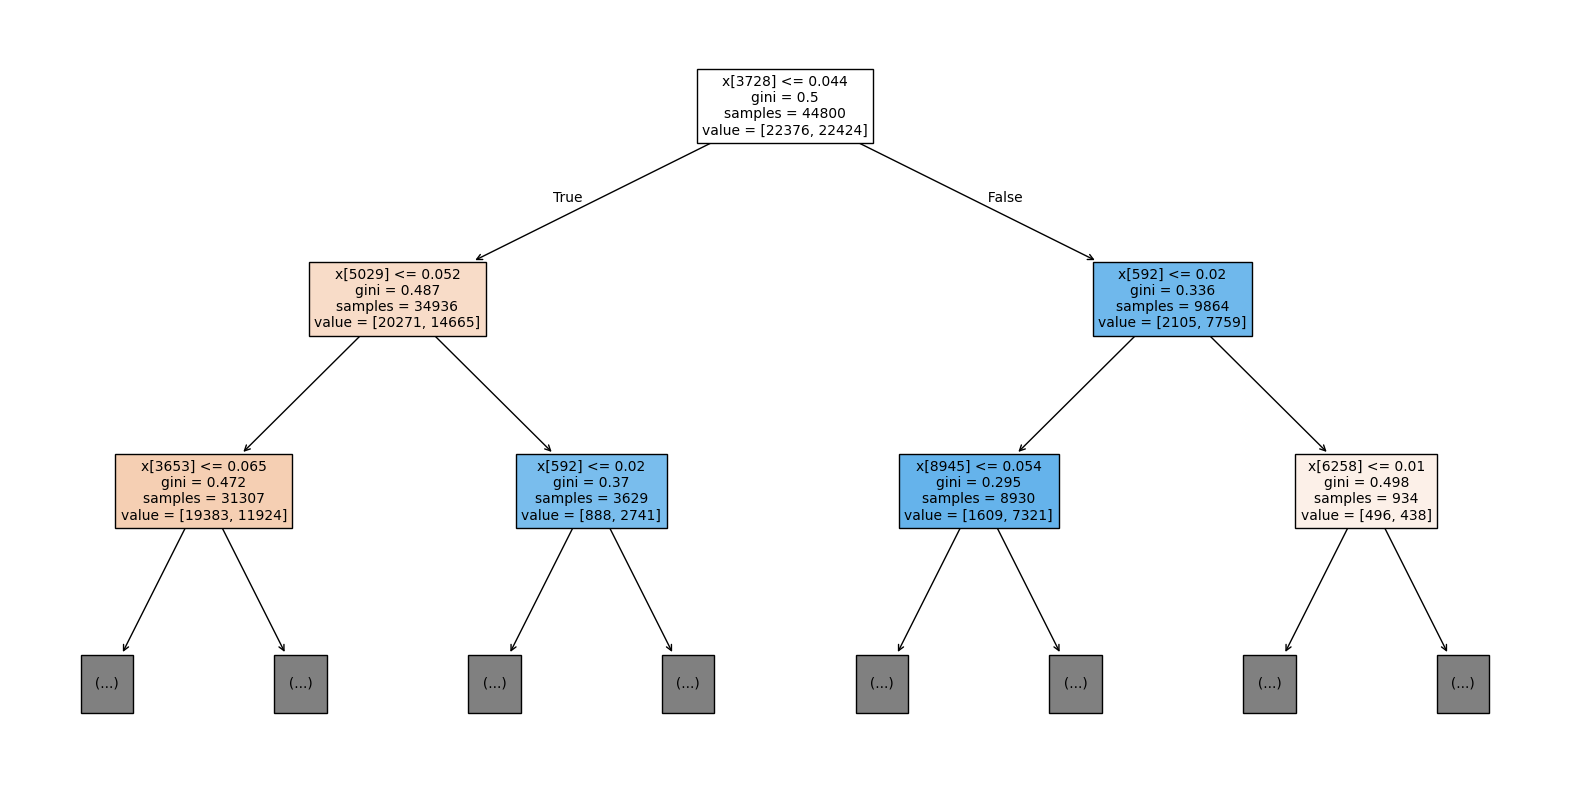

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(clf, max_depth=2, fontsize=10, filled=True)
plt.show()

In [17]:
import gradio as gr
def preprocess(text):
    doc = nlp(text)
    lemmas = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space and token.lemma_.isalpha()
    ]
    return " ".join(lemmas)

def predict_review(review):
    if not review.strip():
        return "Please enter a review!"
    cleaned = preprocess(review)
    vectorized = vectorizer.transform([cleaned])
    prediction = clf.predict(vectorized)[0]
    return "Positive Review" if prediction == 1 else "Negative Review"


gr.Interface(fn=predict_review, inputs="text", outputs="text", title="Rating Predictor").launch(inline=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
